In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import heapq

In [2]:
#Preprocessing
col_to_drop = ['fin_neg','fin_neu','fin_pos', 'fin_subheading', 'fin_title','news_kids', 'news_neg', 'news_neu',
       'news_pos', 'news_score', 'news_title', 'news_url','reddit_domain', 'reddit_neg', 'reddit_neu',
       'reddit_num_comments', 'reddit_pos', 'reddit_score', 'reddit_title',
       'symbol', 'tweet_favorites', 'tweet_hashtags',
       'tweet_neg', 'tweet_neu', 'tweet_pos', 'tweet_retweets', 'tweet_text','asset_name','name']

col_to_drop_crypto = ['fin_neg','fin_neu','fin_pos', 'fin_subheading', 'fin_title','news_kids', 'news_neg', 'news_neu',
       'news_pos', 'news_score', 'news_title', 'news_url','reddit_domain', 'reddit_neg', 'reddit_neu',
       'reddit_num_comments', 'reddit_pos', 'reddit_score', 'reddit_title',
       'symbol', 'tweet_favorites', 'tweet_hashtags',
       'tweet_neg', 'tweet_neu', 'tweet_pos', 'tweet_retweets', 'tweet_text','asset_name']


def preprocessing(stock_pair):
    df = stock_pair["data"].drop(columns = col_to_drop,axis=1)
    df = df.astype(float)
    for col in df.columns:
        df[col] = df[col].fillna(df[col].mean())
    return df

def preprocessing_crypto(crypto_pair):
    df = crypto_pair["data"].drop(columns = col_to_drop_crypto,axis=1)
    df = df.astype(float)
    for col in df.columns:
        df[col] = df[col].fillna(df[col].mean())
    return df

In [3]:
def create_predictors(df):
    predictors = pd.DataFrame({"sma20":df.open.rolling(window=20).mean()})
    predictors["sma40"] = df.open.rolling(window=40).mean()
    predictors["sma20_1"] = predictors.sma20.shift(1)
    predictors["sma20_increment"] = predictors.sma20.diff()  
    predictors["sma20_1_increment"] = predictors.sma20_1.diff()
    predictors["sma40_increment"] = predictors.sma40.diff()
    predictors["vol_increment"] = df.volume.diff()
    predictors["vol_rel_increment"] = df.volume.diff() / df.volume
    predictors["open_1"] = df.open.shift(1)
    predictors["open_incr"] = df.open - df.open.shift(1)
    predictors["open"] = df.open
    predictors['ema20'] = df.open.ewm(span=20,adjust=False).mean()
    predictors["ema20_1"] = predictors.ema20.shift(1)
    predictors["ema20_increment"] = predictors.ema20.diff()  
    predictors['ema40'] = df.open.ewm(span=40,adjust=False).mean()
    predictors["ema40_1"] = predictors.ema40.shift(1)
    predictors["ema40_increment"] = predictors.ema40.diff() 
    predictors["ema40_1_increment"] = predictors.ema40_1.diff()
    predictors["high"] = df.high
    predictors["low"] = df.low
    predictors["close"] = df.close
    predictors['fin_compound'] = df.fin_compound
    predictors['news_compound'] = df.news_compound
    predictors['reddit_compound'] = df.reddit_compound
    predictors['tweet_compound'] = df.tweet_compound
    return predictors.dropna()


def create_predictors_crypto(df):
    predictors = pd.DataFrame({"sma20":df.open.rolling(window=20).mean()})
    predictors["sma40"] = df.open.rolling(window=40).mean()
    predictors["sma20_1"] = predictors.sma20.shift(1)
    predictors["sma20_increment"] = predictors.sma20.diff() 
    predictors["sma40_increment"] = predictors.sma40.diff()  
    predictors["sma20_1_increment"] = predictors.sma20_1.diff()
    predictors["vol_increment"] = df.volumefrom.diff()
    predictors["vol_rel_increment"] = df.volumefrom.diff() / df.volumefrom   
    predictors["open_1"] = df.open.shift(1)
    predictors["open_incr"] = df.open - df.open.shift(1)
    predictors["open"] = df.open
    predictors['ema20'] = df.open.ewm(span=20,adjust=False).mean()
    predictors['ema40'] = df.open.ewm(span=40,adjust=False).mean()
    predictors["ema20_increment"] = predictors.ema20.diff()  
    predictors["ema40_1"] = predictors.ema40.shift(1)
    predictors["ema40_increment"] = predictors.ema40.diff() 
    predictors["ema40_1_increment"] = predictors.ema40_1.diff()
    predictors["high"] = df.high
    predictors["low"] = df.low
    predictors["close"] = df.close
    predictors['fin_compound'] = df.fin_compound
    predictors['news_compound'] = df.news_compound
    predictors['reddit_compound'] = df.reddit_compound
    predictors['tweet_compound'] = df.tweet_compound
    return predictors.dropna()


In [4]:
#Create target test and training
def create_test_target(Predictors):
    target = pd.DataFrame({"value":Predictors.sma20.shift(-1) - Predictors.sma20}).dropna()
    X = pd.merge(Predictors, target,left_index=True,right_index=True)[Predictors.columns]
    y = pd.merge(Predictors, target,left_index=True,right_index=True)[target.columns]
    train_samples = int(X.shape[0] * 0.65)
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return target,X_train,X_test,y_train,y_test

In [5]:
#Creating the model

n_estimators = [150, 200, 250, 450, 500, 550, 1000]
max_depth = [1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

def model(target,X_train,X_test,y_train,y_test):
    def getBinary(val):
        if val>0:
            return 1
        else:
            return 0
    
    y_test_binary = pd.DataFrame(y_test["value"].apply(getBinary))
    
    best_depth = 0
    best_estimator = 0
    max_score = 0

    for n in n_estimators:
        for md in max_depth:
            model = xgb.XGBRegressor(gamma=0.0,n_estimators=n,base_score=0.7,colsample_bytree=1,learning_rate=0.01,max_depth=md,verbosity=0)
            xgbModel = model.fit(X_train,y_train.value.apply(getBinary))
            y_predicted = model.predict(X_test)
            y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]
            score = accuracy_score(y_test_binary, y_predicted_binary)
            if score > max_score:
                max_score = score
                best_depth = md
                best_estimator = n
                best_y_predicted_binary = y_predicted_binary
                best_model = xgbModel
#    print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))
    return y_test_binary,best_y_predicted_binary,max_score,best_model

In [6]:
#To merge the predicted values with the original dataframe
def merge_original(y_test_binary,y_predicted_binary,stock_pair):
    y_test_binary['predicted'] = y_predicted_binary
    merged = pd.merge(stock_pair['data'], y_test_binary,left_index=True,right_index=True)
    return merged

In [7]:
#Reading the data files
df_stock = pd.read_json("C:\\Users\\rishb\\tradespade\\Code\\Data_Collection\\Hourly-Processed-Data\\Final Data\\processed_stocks.json")
df_crypto = pd.read_json("C:\\Users\\rishb//tradespade\\Code\\Data_Collection\\Hourly-Processed-Data\\Final Data\\processed_crypto.json")

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

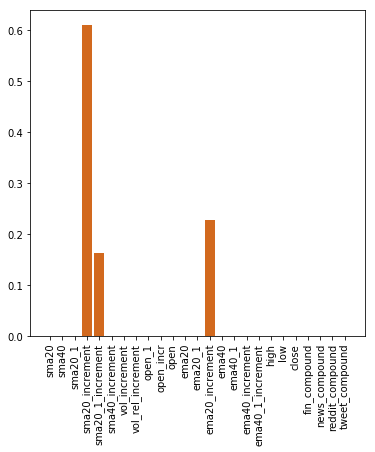

Walmart 0.9343971631205674


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

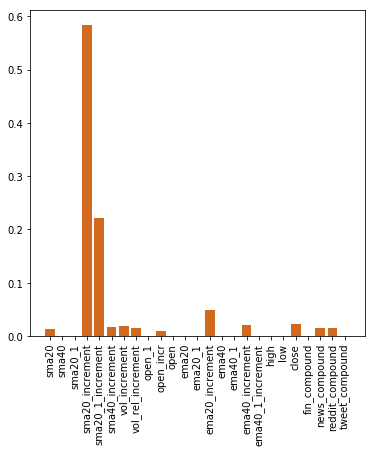

Microsoft 0.9095744680851063


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

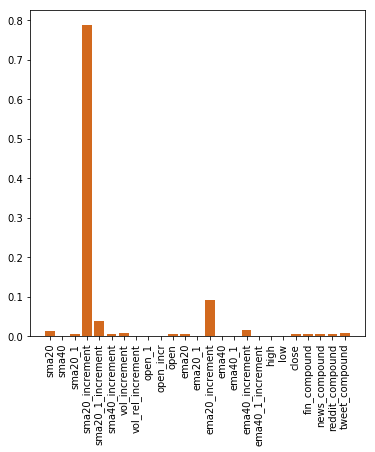

Home_Depot 0.8812056737588653


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

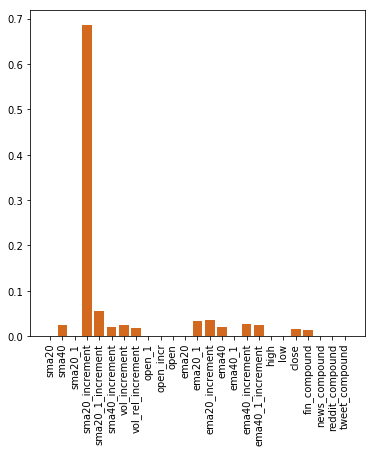

Alphabet 0.9148936170212766


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

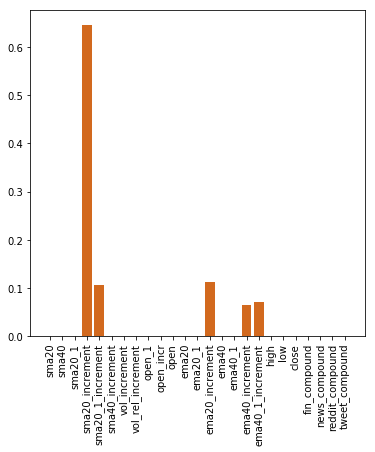

Apple 0.9095744680851063


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

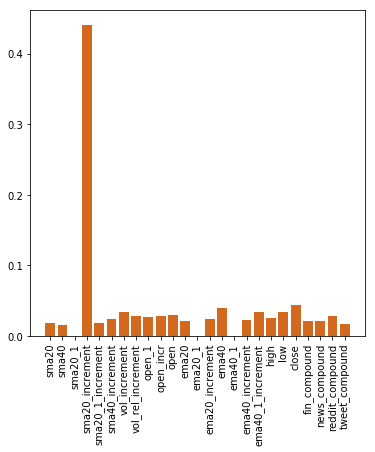

Wells_Fargo 0.8918439716312057


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

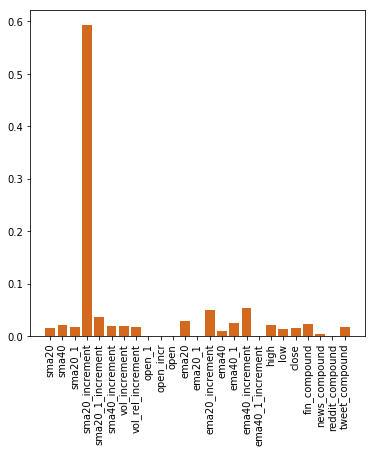

Chevron 0.9148936170212766


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

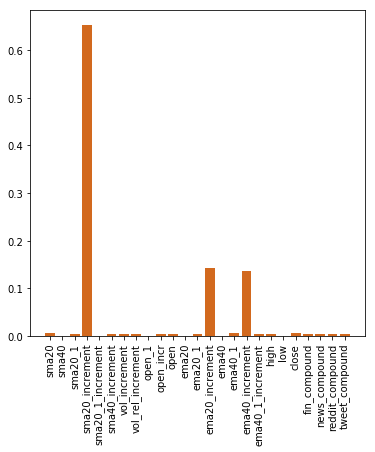

Coca-Cola 0.9131205673758865


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

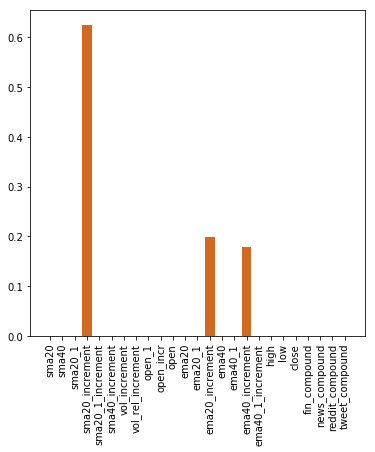

Exxon_Mobil 0.9219858156028369
The average accuracy for stocks is: 0.9101654846335696


In [8]:
#For stocks
stock_sybmol_list=['WMT', 'US1.MSFT', 'US1.HD', 'US2.GOOG', 'US2.AAPL', 'US1.WFC',
       'US1.CVX', 'US1.KO', 'US1.XOM']
stock_name_list = ['Walmart', 'Microsoft', 'Home_Depot',
       'Alphabet', 'Apple', 'Wells_Fargo',
       'Chevron', 'Coca-Cola',
       'Exxon_Mobil']

mylist = list()

for stock,stock_name in zip(stock_sybmol_list,stock_name_list):
    stock = {"stock_name":stock_name, "data": df_stock[df_stock['symbol']==stock]}
    stock["data"]=stock["data"].set_index("created_utc")
    mylist.append(stock)
    

total_acc = 0
for dict1 in mylist:
    df = preprocessing(dict1)
    Predictors = create_predictors(df)
    target,X_train,X_test,y_train,y_test = create_test_target(Predictors)
    y_test_binary,y_predicted_binary,acc,xgbModel = model(target,X_train,X_test,y_train,y_test)
    fig = plt.figure(figsize=(6,6))
    plt.xticks(rotation='vertical')
    plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns, color="chocolate")
    plt.show()
    print(dict1['stock_name'],acc)
    merged = merge_original(y_test_binary,y_predicted_binary,dict1)
    merged['accuracy'] = acc
    total_acc+=acc
    dict1['acc']=acc
    dict1['feature_importance']=xgbModel.feature_importances_.tolist()
    dict1['merged'] = merged
    dict1['stock_name'] = dict1['stock_name']+"_with_predicted"
#    dict1["merged"].reset_index().to_json(save_path+dict1['stock_name']+'.json',orient = 'records')

    
    
print("The average accuracy for stocks is: {}".format(total_acc/9))


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

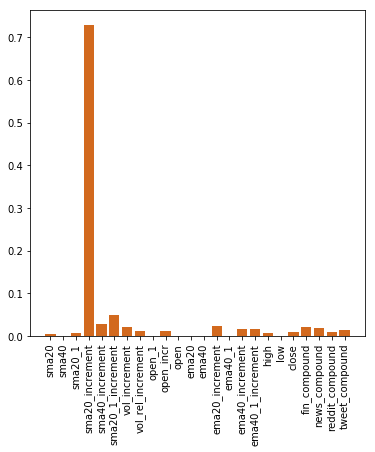

Binance_Coin 0.8941427699816962


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

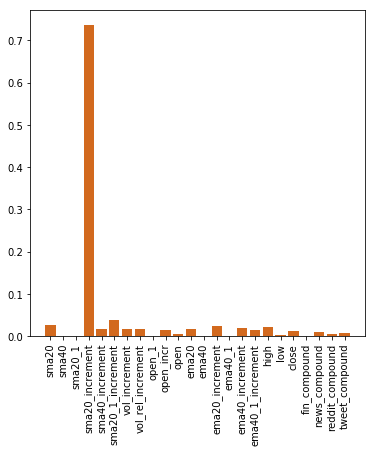

Bitcoin 0.8691275167785235


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

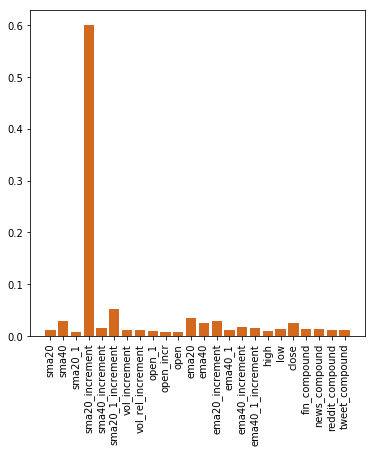

EOS 0.8912529550827423


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

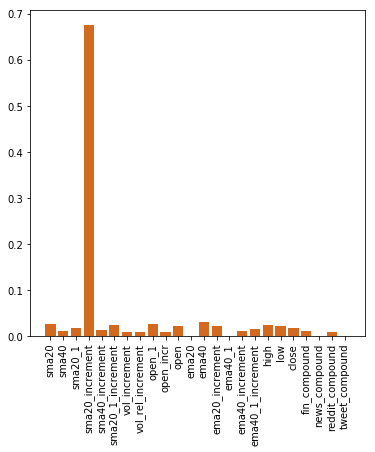

Litecoin 0.8996032956972841


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

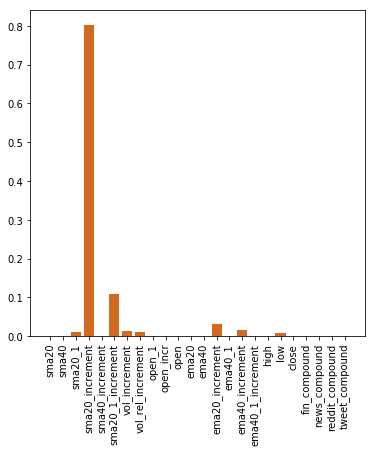

Stellar 0.9026004728132387


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

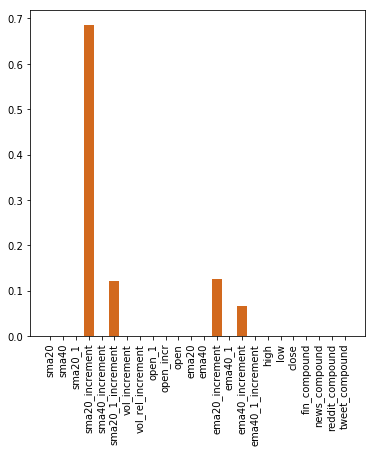

TRON 0.8883632923368022


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

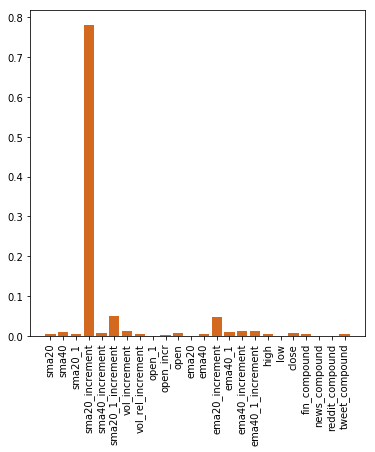

XRP 0.8826106000876041


C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\Anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\rishb\

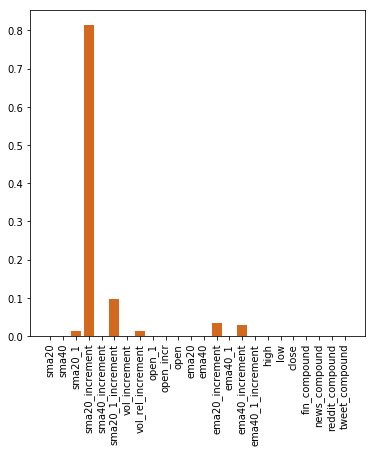

Bitcoin_Cash 0.8552546744036106
Average cryptocurrency accuracy=0.8853694471476877


In [9]:
crypto_symbol_list=['BNB', 'BTC', 'EOS', 'LTC', 'XLM', 'TRX', 'XRP', 'BCH'#, 'ETH'
                   ]
crypto_name_list = ['Binance_Coin',
 'Bitcoin',
 'EOS',
 'Litecoin',
 'Stellar',
 'TRON',
 'XRP',
 'Bitcoin_Cash'
# ,'Ethereum'
    ]

mylist_crypto = list()

for crypto,crypto_name in zip(crypto_symbol_list,crypto_name_list):
    crypto = {"crypto_name":crypto_name, "data": df_crypto[df_crypto['symbol']==crypto]}
    crypto["data"]=crypto["data"].set_index("created_utc")
    mylist_crypto.append(crypto)
    

save_path = "C:\\Users\\rishb\\predicted_crypto\\"

#n_estimators = [150, 200, 250, 450, 500, 550, 1000]
#max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

total_acc_crypto = 0
for dict1 in mylist_crypto:
    df = preprocessing_crypto(dict1)
    Predictors = create_predictors_crypto(df)
    target,X_train,X_test,y_train,y_test = create_test_target(Predictors)
    y_test_binary,y_predicted_binary,acc,xgbModel = model(target,X_train,X_test,y_train,y_test)
    merged = merge_original(y_test_binary,y_predicted_binary,dict1)
    merged['accuracy'] = acc
    fig = plt.figure(figsize=(6,6))
    plt.xticks(rotation='vertical')
    plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns, color="chocolate")
    plt.show()
    print(dict1['crypto_name'],acc)
    dict1['acc']=acc
    dict1['feature_importance']=xgbModel.feature_importances_.tolist()
    dict1['merged'] = merged
    dict1['crypto_name'] = dict1['crypto_name']+"_with_predicted"
    total_acc_crypto+=acc
#    dict1["merged"].reset_index().to_json(save_path+dict1['crypto_name']+'.json',orient = 'records')

print("Average cryptocurrency accuracy={}".format(total_acc_crypto/8))

In [43]:
#Feature Analysis
s = list()
c = list()
for d in mylist:
    s.append(d['feature_importance'])
    
for d in mylist_crypto:
    c.append(d['feature_importance'])

feat_imp_stock = [sum(e)/len(e) for e in zip(*l)]
feat_imp_crypto = [sum(e)/len(e) for e in zip(*c)]
features = ['sma20', 'sma40', 'sma20_1', 'sma20_increment', 'sma20_1_increment', 'sma40_increment', 'vol_increment', 'vol_rel_increment', 'open_1', 'open_incr', 'open', 'ema20', 'ema20_1', 'ema20_increment', 'ema40', 'ema40_1', 'ema40_increment', 'ema40_1_increment', 'high', 'low', 'close', 'fin_compound', 'news_compound', 'reddit_compound', 'tweet_compound']
features_crypto = ['sma20', 'sma40', 'sma20_1', 'sma20_increment', 'sma40_increment', 'sma20_1_increment', 'vol_increment', 'vol_rel_increment', 'open_1', 'open_incr', 'open', 'ema20', 'ema40', 'ema20_increment', 'ema40_1', 'ema40_increment', 'ema40_1_increment', 'high', 'low', 'close', 'fin_compound', 'news_compound', 'reddit_compound', 'tweet_compound']
feature_dict_stock = {k:v for k,v in zip(features,feat_imp_stock)}
feature_dict_crypto= {k:v for k,v in zip(features_crypto,feat_imp_crypto)}


print(heapq.nlargest(5, feature_dict_stock.items(), key=lambda i: i[1]))
print(heapq.nsmallest(5, feature_dict_stock.items(), key=lambda i: i[1]))
print(heapq.nlargest(5, feature_dict_crypto.items(), key=lambda i: i[1]))
print(heapq.nsmallest(5, feature_dict_crypto.items(), key=lambda i: i[1]))
fig = plt.figure(figsize=(6,6))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(feat_imp_stock))], feat_imp_stock, tick_label=features, color="chocolate")
plt.title("Average feature importance for stocks")
plt.show()

fig = plt.figure(figsize=(6,6))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(feat_imp_crypto))], feat_imp_crypto, tick_label=features_crypto, color="chocolate")
plt.title("Average feature importance for cryptocurrencies")
plt.show()

[('open_1', 0.002971383018626107), ('sma20_1', 0.0030296132641120087), ('ema40_1', 0.0034880299580335203), ('ema20_1', 0.004163519427594211), ('open', 0.004275817605149414)]
[('ema40_1', 0.002608428359963), ('reddit_compound', 0.004455432062968612), ('open_1', 0.004472862463444471), ('tweet_compound', 0.0048038417007774115), ('open', 0.005178143735975027)]
